In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
from shapely.geometry import Point
import plotly.graph_objects as go
import requests
from bs4 import BeautifulSoup
from time import sleep
import functools
from shapely import wkt

/Users/berendmarkhorst/Library/Mobile Documents/com~apple~CloudDocs/PhD/READINESS/08 - Trondheim/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


# Reading the data

In [78]:
# Some constants
min_longitude = -3
max_longitude = 11
min_latitude = 50
max_latitude = 70

In [79]:
# All the pipe lines, source: https://map.gassco.eu/map
pipelines = [
    "Europipe I",
    "Europipe II",
    "Franpipe",
    "Gjøa",
    "Haltenpipe",
    "Kvitebjørn",
    "Langeled North",
    "Langeled South",
    "Norne",
    "Norpipe",
    "OGT",
    "Ormen Lange",
    "Polarled",
    "Statpipe",
    "Tampen Link",
    "Vesterled",
    "Zeepipe",
    "Zeepipe II A",
    "Zeepipe II B"]
print(f"Number of pipelines: {len(pipelines)}")

Number of pipelines: 19


In [80]:
shapefile_path = 'Data/pipLine/pipLine.shp'

In [81]:
# Note: Sleipner - Easington zit er niet in omdat het een Co2 injection is...
gdf = gpd.read_file(shapefile_path)

#dropna
gdf = gdf.dropna(subset=["mapLabel"])

gdf[gdf["mapLabel"].str.contains("Langeled")]

,pipName,idPipeline,mapLabel,belongs_to,curOperNam,curPhase,curPhDate,fromFacili,toFacility,mainGrp,...,WaterDepth,medium,idBelongTo,idFrmFacil,idToFacili,idOperator,dtUpdated,FactUrl,MapUrl,geometry
51,"42"" Gas NYHAMNA, SLEIPNER R",369461,Langeled,GASSLED,Gassco AS,IN SERVICE,2007-09-13,NYHAMNA,SLEIPNER R,Transportation,...,360.0,Gas,2252643,364693,277797,1944954,2024-01-02,https://factpages.sodir.no/factpages/default.a...,https://factmaps.sodir.no/factmaps/3_0/?run=Pi...,"LINESTRING (6.94577 62.85156, 6.96004 62.86068..."
52,"44"" Co2 injection SLEIPNER R, EASINGTON",369498,Langeled,GASSLED,Gassco AS,IN SERVICE,2006-10-01,SLEIPNER R,EASINGTON,Transportation,...,83.0,Co2 injection,2252643,277797,369424,1944954,2024-05-25,https://factpages.sodir.no/factpages/default.a...,https://factmaps.sodir.no/factmaps/3_0/?run=Pi...,"LINESTRING (1.90132 58.36498, 1.88004 58.35670..."


In [82]:
# Read the data (source: https://kartkatalog.geonorge.no/metadata/pipelines/3a31a1f1-f836-4565-937f-731286fb8baa)
gdf = gpd.read_file(shapefile_path)

# Drop the NaN values in the mapLabel column
gdf = gdf.dropna(subset=["mapLabel"])

# Filter on the in service pipelines
gdf_filtered = gdf[gdf['curPhase'] == 'IN SERVICE']

# Filter on the gas pipelines
gdf_filtered = gdf_filtered[gdf_filtered['medium'] == 'Gas']

# Convert multi-part geometries to single-part
gdf_single = gdf_filtered.explode(index_parts=False).reset_index(drop=True)

# Drop duplicates
gdf_single = gdf_single.drop_duplicates(subset = ["mapLabel", "fromFacili", "toFacility"], keep="first")

print(f"Number of rows in the GeoDataFrame: {len(gdf_single)}")
gdf_single.head()

Number of rows in the GeoDataFrame: 43


,pipName,idPipeline,mapLabel,belongs_to,curOperNam,curPhase,curPhDate,fromFacili,toFacility,mainGrp,...,WaterDepth,medium,idBelongTo,idFrmFacil,idToFacili,idOperator,dtUpdated,FactUrl,MapUrl,geometry
0,"42"" Gas ÅSGARD ERB, KÅRSTØ",307674,Åsgard Transport,GASSLED,Gassco AS,IN SERVICE,2000-10-04,ÅSGARD ERB,KÅRSTØ,Transportation,...,372.0,Gas,2252643,282613,286169,1944954,2024-01-02,https://factpages.sodir.no/factpages/default.a...,https://factmaps.sodir.no/factmaps/3_0/?run=Pi...,"LINESTRING (4.68854 62.30273, 4.72014 62.33196..."
2,"40"" Gas ZEEPIPE-SCP, ZEEBRUGGE",310326,Zeepipe I,GASSLED,Gassco AS,IN SERVICE,1993-10-01,ZEEPIPE-SCP,ZEEBRUGGE,Transportation,...,39.9,Gas,2252643,286533,286281,1944954,2024-01-02,https://factpages.sodir.no/factpages/default.a...,https://factmaps.sodir.no/factmaps/3_0/?run=Pi...,"LINESTRING (3.29982 54.78949, 3.28226 54.62916..."
3,"30"" Gas STAT-SSTC, KÅRSTØ",313556,Statpipe,GASSLED,Gassco AS,IN SERVICE,1985-10-01,STAT-SSTC,KÅRSTØ,Transportation,...,300.0,Gas,2252643,286365,286169,1944954,2024-01-02,https://factpages.sodir.no/factpages/default.a...,https://factmaps.sodir.no/factmaps/3_0/?run=Pi...,"LINESTRING (1.84594 61.18583, 1.85618 61.17402..."
4,"36"" Gas TROLL A, KOLLSNES",314542,Troll Gassrør P10,TROLL I,Equinor Energy AS,IN SERVICE,1996-10-01,TROLL A,KOLLSNES,Transportation,...,347.0,Gas,101998,278329,286729,32011216,2024-01-02,https://factpages.sodir.no/factpages/default.a...,https://factmaps.sodir.no/factmaps/3_0/?run=Pi...,"LINESTRING (4.83583 60.55018, 4.79784 60.52770..."
5,"36"" Gas TROLL A, KOLLSNES",314576,Troll Gassrør P11,TROLL I,Equinor Energy AS,IN SERVICE,1997-10-01,TROLL A,KOLLSNES,Transportation,...,347.0,Gas,101998,278329,286729,32011216,2024-01-02,https://factpages.sodir.no/factpages/default.a...,https://factmaps.sodir.no/factmaps/3_0/?run=Pi...,"LINESTRING (3.73520 60.64427, 3.73902 60.64368..."


In [83]:
# Only select the pipelines that are on the map of the Gassco website
pipelines_first = [pipeline.split(" ")[0] for pipeline in pipelines]
gdf_pipes = gdf_single[gdf_single["mapLabel"].str.startswith(tuple(pipelines_first))]

# Watch out with the following line of code! I added manually info about Asgar and Baltic pipes!
# gdf_pipes.to_excel("Data/input_data.xlsx")

In [84]:
extra_pipes = pd.read_excel("Data/input_data.xlsx", index_col=0)
extra_pipes = extra_pipes.tail(n=4)

# After a discussion with Ruud, we add Langeled (from GeoNorge), Asgar Transport (manually), and Baltic pipe (manually). Source of picture: https://www.norskpetroleum.no/en/production-and-exports/the-oil-and-gas-pipeline-system/
extra_pipes["geometry"] = extra_pipes["geometry"].apply(wkt.loads)
extra_pipes = gpd.GeoDataFrame(extra_pipes)
extra_pipes = extra_pipes.explode(index_parts=False).reset_index(drop=True)
gdf_pipes = gpd.GeoDataFrame(pd.concat([gdf_pipes, extra_pipes], ignore_index=True))

/Users/berendmarkhorst/Library/Mobile Documents/com~apple~CloudDocs/PhD/READINESS/08 - Trondheim/venv/lib/python3.8/site-packages/geopandas/array.py:1486: UserWarning:

CRS not set for some of the concatenation inputs. Setting output's CRS as ED50 (the single non-null crs provided).



In [85]:
# Add Langeled from Sleipner R to Easington
gdf_pipes = gpd.GeoDataFrame(pd.concat([gdf_pipes, gdf[(gdf["mapLabel"].str.contains("Langeled")) & (gdf["medium"] == "Co2 injection")]], ignore_index=True))

# Add Baltic pipeline
# I need to find this data online...

print(f"Number of rows in the GeoDataFrame: {len(gdf_pipes)}")

Number of rows in the GeoDataFrame: 35


In [86]:
# As you can see, the pipeline data is connected with intermediate nodes, such as H-7 BP, etc.
gdf_pipes[gdf_pipes["mapLabel"].str.startswith("Norpipe")]

,pipName,idPipeline,mapLabel,belongs_to,curOperNam,curPhase,curPhDate,fromFacili,toFacility,mainGrp,...,medium,idBelongTo,idFrmFacil,idToFacili,idOperator,dtUpdated,FactUrl,MapUrl,geometry,Capacity
3,"36"" Gas NORPIPE Y, B-11",319166.0,Norpipe Gassledning,GASSLED,Gassco AS,IN SERVICE,1977-09-17,NORPIPE Y,B-11,Transportation,...,Gas,2252643.0,287065.0,277265.0,1944954.0,2024-01-02,https://factpages.sodir.no/factpages/default.a...,https://factmaps.sodir.no/factmaps/3_0/?run=Pi...,"LINESTRING (3.33050 56.49037, 3.33215 56.48739...",NaN
6,"36"" Gas H-7 BP, EMDEN",321784.0,Norpipe Gassledning,GASSLED,Gassco AS,IN SERVICE,1977-09-17,H-7 BP,EMDEN,Transportation,...,Gas,2252643.0,377218.0,286141.0,1944954.0,2024-01-02,https://factpages.sodir.no/factpages/default.a...,https://factmaps.sodir.no/factmaps/3_0/?run=Pi...,"LINESTRING (6.04063 54.50580, 6.04477 54.50273...",NaN
14,"36"" Gas B-11, H-7 BP",324844.0,Norpipe Gassledning,GASSLED,Gassco AS,IN SERVICE,1977-09-17,B-11,H-7 BP,Transportation,...,Gas,2252643.0,277265.0,377218.0,1944954.0,2024-01-02,https://factpages.sodir.no/factpages/default.a...,https://factmaps.sodir.no/factmaps/3_0/?run=Pi...,"LINESTRING (4.55695 55.45898, 4.65178 55.39937...",NaN
19,"36"" Gas EKOFISK J, NORPIPE Y",326918.0,Norpipe Gassledning,GASSLED,Gassco AS,IN SERVICE,1998-08-18,EKOFISK J,NORPIPE Y,Transportation,...,Gas,2252643.0,277937.0,287065.0,1944954.0,2024-01-02,https://factpages.sodir.no/factpages/default.a...,https://factmaps.sodir.no/factmaps/3_0/?run=Pi...,"LINESTRING (3.33050 56.49037, 3.30702 56.51269...",NaN


In [87]:
# I compute the source and destination coordinates for each pipeline
gdf_pipes["Source Lon"] = gdf_pipes["geometry"].apply(lambda x: x.coords[0][0])
gdf_pipes["Source Lat"] = gdf_pipes["geometry"].apply(lambda x: x.coords[0][1])
gdf_pipes["Dest Lon"] = gdf_pipes["geometry"].apply(lambda x: x.coords[-1][0])
gdf_pipes["Dest Lat"] = gdf_pipes["geometry"].apply(lambda x: x.coords[-1][1])


In [88]:
# I compute the longitude and latitude of the nodes

nodes = gdf_pipes["fromFacili"].unique().tolist() + gdf_pipes["toFacility"].unique().tolist()
node_df = pd.DataFrame(columns=["Node", "Lon", "Lat"], data=[[node, None, None] for node in nodes])
for node in nodes:
    if node in gdf_pipes["fromFacili"].unique():
        node_df.loc[node_df["Node"] == node, "Lon"] = gdf_pipes[gdf_pipes["fromFacili"] == node]["Source Lon"].values[0]
        node_df.loc[node_df["Node"] == node, "Lat"] = gdf_pipes[gdf_pipes["fromFacili"] == node]["Source Lat"].values[0]
    else:
        if node == "BALTIC ENTRANCE": # Baltic pipes is split in two!
            idx = gdf_pipes[gdf_pipes["toFacility"] == node]["Dest Lon"].argmin()
            node_df.loc[node_df["Node"] == node, "Lon"] = gdf_pipes[gdf_pipes["toFacility"] == node]["Dest Lon"].values[idx]
            node_df.loc[node_df["Node"] == node, "Lat"] = gdf_pipes[gdf_pipes["toFacility"] == node]["Dest Lat"].values[idx]
        else:
            node_df.loc[node_df["Node"] == node, "Lon"] = gdf_pipes[gdf_pipes["toFacility"] == node]["Dest Lon"].values[0]
            node_df.loc[node_df["Node"] == node, "Lat"] = gdf_pipes[gdf_pipes["toFacility"] == node]["Dest Lat"].values[0]

node_df

,Node,Lon,Lat
0,ZEEPIPE-SCP,3.299816,54.789494
1,STAT-SSTC,1.845936,61.18583
2,NORNE ERB,8.078544,66.029331
3,NORPIPE Y,3.330503,56.490369
4,SLEIPNER R,1.915866,58.364944
5,H-7 BP,6.040634,54.505801
6,HEIDRUN,7.320245,65.3215
7,HEIMDAL,2.234523,59.570738
8,HEIMDAL HRP,2.221921,59.578405
9,KÅRSTØ,5.186367,59.33348


In [89]:
# Convert node_df to a GeoDataFrame
geometry = [Point(xy) for xy in zip(node_df['Lon'], node_df['Lat'])]
gdf_facilities = gpd.GeoDataFrame(node_df, geometry=geometry)

# Plotting the data

/var/folders/fw/zjz8sscn11z9hzvyq33zv4xh0000gn/T/ipykernel_5424/4097238233.py:2: FutureWarning:

The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.



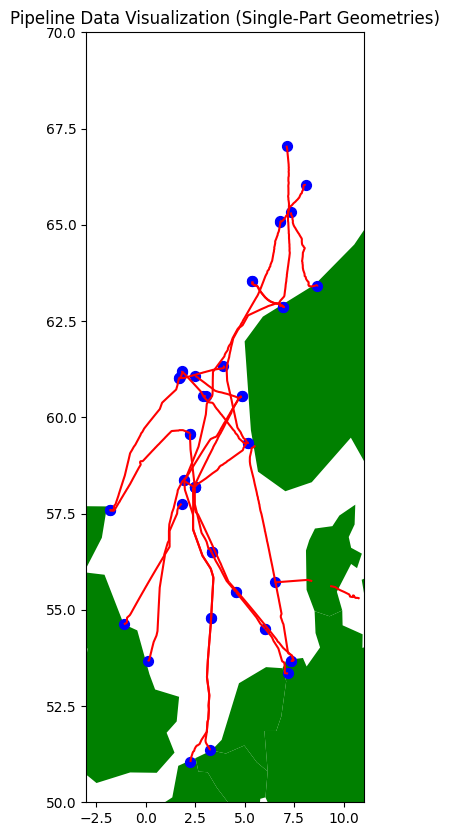

In [90]:
# Load a map of countries from the Natural Earth dataset
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Filter for North West Europe (roughly)
north_west_europe = world[(world['continent'] == 'Europe') &
                          (world['name'].isin(['United Kingdom', 'Ireland', 'France', 'Belgium', 'Netherlands',
                                               'Germany', 'Denmark', 'Norway', 'Sweden']))]

# Ensure both GeoDataFrames use the same CRS
gdf_pipes = gdf_pipes.to_crs(north_west_europe.crs)

# Ensure both GeoDataFrames use the same CRS as the map (north_west_europe)
gdf_facilities = gdf_facilities.set_crs(epsg=4326)  # Assuming your Lon/Lat are in WGS 84 (EPSG:4326)
gdf_facilities = gdf_facilities.to_crs(north_west_europe.crs)

# Plot the single-part geometries
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the map
north_west_europe.plot(ax=ax, color='green')

# Plot the pipelines
gdf_pipes.plot(ax=ax, edgecolor='red')

# Plot the facilities
gdf_facilities.plot(ax=ax, color='blue', marker='o', markersize=50, label='Facilities')

ax.set_xlim([min_longitude, max_longitude])
ax.set_ylim([min_latitude, max_latitude])

# Add basemap
# ctx.add_basemap(ax, source=ctx.providers.Stamen.TonerLite)

ax.set_title('Pipeline Data Visualization (Single-Part Geometries)')
plt.show()

In [91]:
def interactive_plot(gdf_pipes, gdf_facilities, extra_info=False):
    # Reproject both to WGS 84 (EPSG:4326) for compatibility with Plotly
    gdf_pipes = gdf_pipes.to_crs(epsg=4326)
    gdf_facilities = gdf_facilities.to_crs(epsg=4326)

    # Extract coordinates and hover text for the pipelines
    pipe_latitudes = []
    pipe_longitudes = []
    hover_texts = []

    if extra_info:
        gdf_facilities["Hover"] = gdf_facilities["Node"] + " (" + gdf_facilities["Capacity"].astype(str) + " capacity)"
    else:
        gdf_facilities["Hover"] = gdf_facilities["Node"]

    for idx, line in enumerate(gdf_pipes.geometry):
        pipe_name = gdf_pipes.iloc[idx]['mapLabel']  # Assuming you have a 'name' column for pipelines
        if extra_info:
            pipe_name += f" ({gdf_pipes.iloc[idx]['Capacity']} capacity)"
        if line.geom_type == 'LineString':
            x, y = line.xy
            pipe_longitudes.extend(x)
            pipe_latitudes.extend(y)
            hover_texts.extend([pipe_name] * len(x))
            pipe_longitudes.append(None)  # None to break the line between different LineStrings
            pipe_latitudes.append(None)
            hover_texts.append(None)
        elif line.geom_type == 'MultiLineString':
            for linestring in line:
                x, y = linestring.xy
                pipe_longitudes.extend(x)
                pipe_latitudes.extend(y)
                hover_texts.extend([pipe_name] * len(x))
                pipe_longitudes.append(None)
                pipe_latitudes.append(None)
                hover_texts.append(None)

    # Create a Plotly figure
    fig = go.Figure()

    # Add the pipelines (lines) to the plot with hover text
    fig.add_trace(go.Scattermapbox(
        lat=pipe_latitudes,
        lon=pipe_longitudes,
        mode='lines',
        line=dict(width=2, color='red'),
        text=hover_texts,  # Add hover text
        hoverinfo='text',
        name='Pipelines'
    ))

    # Add the facilities (points) to the plot
    fig.add_trace(go.Scattermapbox(
        lat=gdf_facilities.geometry.y,
        lon=gdf_facilities.geometry.x,
        mode='markers',
        marker=go.scattermapbox.Marker(size=10, color='blue'),
        text=gdf_facilities['Hover'],  # Assuming you have a column 'facility_name'
        hoverinfo='text',
        name='Facilities'
    ))

    # Set up the layout for the map
    fig.update_layout(
        mapbox_style="open-street-map",
        mapbox_zoom=3,
        mapbox_center={"lat": 60, "lon": 15.2551},  # Center on North West Europe
        margin={"r":0,"t":0,"l":0,"b":0}
    )

    # Add title
    fig.update_layout(title_text='Pipeline and Facilities Visualization')

    fig.show()

    return fig

_ = interactive_plot(gdf_pipes, gdf_facilities, extra_info=False)

In [92]:
print(f"Number of nodes: {len(node_df)}")
print(f"Number of pipelines: {len(gdf_pipes)}")

Number of nodes: 52
Number of pipelines: 35


# Scraping data from Gassco

In [96]:
@functools.lru_cache(maxsize=None)  # maxsize=None means the cache can grow without bound
def scrape(pipeline, url):
    # Send a GET request to the webpage
    response = requests.get(url)

    # Check if the request was successful
    if response.status_code == 200:
        # Parse the webpage content
        soup = BeautifulSoup(response.content, 'html.parser')

        # Extract the required data
        data = []
        facts = soup.find_all('div', class_='facts')
        for fact in facts:
            from_value = fact.find('dt', text='Fra').find_next('dd').text.strip()
            to_value = fact.find('dt', text='Til').find_next('dd').text.strip()
            length_value = fact.find('dt', text='Lengde').find_next('dd').text.strip()
            diameter_value = fact.find('dt', text='Diameter').find_next('dd').text.strip()
            capacity_value = fact.find('dt', text='Kapasitet').find_next('dd').text.strip()
            operator_value = fact.find('dt', text='Operatør').find_next('dd').text.strip()

            # Store the data in a dictionary
            data.append({
                'Pipeline': pipeline,
                'From': from_value,
                'To': to_value,
                'Length': length_value,
                'Diameter': diameter_value,
                'Capacity': capacity_value,
                'Operator': operator_value
            })

        # Convert the data to a Pandas DataFrame
        df = pd.DataFrame(data)

        # Print or save the DataFrame
        # print(df)
        # df.to_csv('pipeline_data.csv', index=False)  # To save as CSV
    else:
        print(f"Failed to retrieve the webpage. Status code: {response.status_code}")

    return df


In [97]:
# Define the URL of the webpage to scrape
url = "https://map.gassco.eu/rorledninger/europipe"

scrape("Europipe", url)

/var/folders/fw/zjz8sscn11z9hzvyq33zv4xh0000gn/T/ipykernel_4155/1587467342.py:15: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

/var/folders/fw/zjz8sscn11z9hzvyq33zv4xh0000gn/T/ipykernel_4155/1587467342.py:16: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

/var/folders/fw/zjz8sscn11z9hzvyq33zv4xh0000gn/T/ipykernel_4155/1587467342.py:17: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

/var/folders/fw/zjz8sscn11z9hzvyq33zv4xh0000gn/T/ipykernel_4155/1587467342.py:18: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

/var/folders/fw/zjz8sscn11z9hzvyq33zv4xh0000gn/T/ipykernel_4155/1587467342.py:19: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

/var/folders/fw/zjz8sscn11z9hzvyq33zv4xh0000gn/T/ipykernel_4155/1587467342.py:20

,Pipeline,From,To,Length,Diameter,Capacity,Operator
0,Europipe,Draupner E,Dornum/Emden,620 km,"40""",45.7 mill,Gassco


In [ ]:
# All URLs from Gassco
urls = ["https://map.gassco.eu/rorledninger/europipe",
        "https://map.gassco.eu/rorledninger/europipe-ii",
        "https://map.gassco.eu/rorledninger/franpipe",
        "https://map.gassco.eu/rorledninger/gjoa-gas-pipe",
        "https://map.gassco.eu/rorledninger/haltenpipe",
        "https://map.gassco.eu/rorledninger/kvitebjorn-pipeline",
        "https://map.gassco.eu/rorledninger/langeled-north",
        "https://map.gassco.eu/rorledninger/langeled-south",
        "https://map.gassco.eu/rorledninger/norne-gas-transport",
        "https://map.gassco.eu/rorledninger/norpipe",
        "https://map.gassco.eu/rorledninger/ogt",
        "https://map.gassco.eu/rorledninger/ormen-lange-nyhamna",
        "https://map.gassco.eu/rorledninger/polarled",
        "https://map.gassco.eu/rorledninger/statpipe",
        "https://map.gassco.eu/rorledninger/tampen-link",
        "https://map.gassco.eu/rorledninger/vesterled",
        "https://map.gassco.eu/rorledninger/zeepipe",
        "https://map.gassco.eu/rorledninger/zeepipe-ii-a",
        "https://map.gassco.eu/rorledninger/zeepipe-ii-b"]
scrape_df = pd.DataFrame()

for (url, pipeline) in zip(urls, pipelines):
    sleep(5)
    try:
        temp = scrape(pipeline, url)
        scrape_df = pd.concat([scrape_df, temp], ignore_index=True)
        print(f"Scraped data for {pipeline}")
        print(scrape_df)
    except:
        print(f"Failed to scrape data for {pipeline}")

In [99]:
scrape_df

,Pipeline,From,To,Length,Diameter,Capacity,Operator
0,Europipe I,Draupner E,Dornum/Emden,620 km,"40""",45.7 mill,Gassco
1,Europipe II,Kårstø,Dornum,658 km,"42""","73,5 mill",Gassco
2,Franpipe,Draupner E,Dunkerque,840 km,42”,54.2 mill,Gassco
3,Gjøa,Gjøa,FLAGS,131 km,28”,"18,2 mill",Gassco
4,Haltenpipe,Heidrun,Tjeldbergodden,250 km,"16""","4,7",Gassco
5,Kvitebjørn,Kvitebjørn,Kollsnes,147 km,"30""","33,5 mill",Gassco
6,Langeled North,Nyhamna,Sleipner,627 km,"42""",74.7 mill,Gassco
7,Langeled South,Sleipner,Easington,523 km,"44""","73,8 mill",Gassco
8,Norne,Norne,Heidrun,128 km,"16""",11,Gassco
9,Norpipe,Ekofisk,Emden,440 km,"36""",44.4 mill,Gassco


In [105]:
set(pipelines) - set(scrape_df["Pipeline"])

{'Ormen Lange', 'Zeepipe II A', 'Zeepipe II B'}

In [110]:
# Manually inserting the missing data
ormen_lange = {
    "Pipeline": "Ormen Lange",
    "From": "Ormen Lange",
    "To": "Nyhamna",
    "Length": "120 km",
    "Diameter": "30",
    "Capacity": None,
    "Operator": "Shell"}

zeepipe_a = {
    "Pipeline": "Zeepipe II A",
    "From": "Kollsnes",
    "To": "Sleipner",
    "Length": "300 km",
    "Diameter": "40",
    "Capacity": None,
    "Operator": None}

zeepipe_b = {
    "Pipeline": "Zeepipe II B",
    "From": "Kollsnes",
    "To": "Draupner E",
    "Length": "300 km",
    "Diameter": "40",
    "Capacity": None,
    "Operator": "Gassco"}


scrape_df = pd.concat([scrape_df, pd.DataFrame([ormen_lange])], ignore_index=True)
scrape_df = pd.concat([scrape_df, pd.DataFrame([zeepipe_a])], ignore_index=True)
scrape_df = pd.concat([scrape_df, pd.DataFrame([zeepipe_b])], ignore_index=True)

In [113]:
scrape_df.to_csv("Data/pipeline_data.csv", index=False)
scrape_df

,Pipeline,From,To,Length,Diameter,Capacity,Operator
0,Europipe I,Draupner E,Dornum/Emden,620 km,"40""",45.7 mill,Gassco
1,Europipe II,Kårstø,Dornum,658 km,"42""","73,5 mill",Gassco
2,Franpipe,Draupner E,Dunkerque,840 km,42”,54.2 mill,Gassco
3,Gjøa,Gjøa,FLAGS,131 km,28”,"18,2 mill",Gassco
4,Haltenpipe,Heidrun,Tjeldbergodden,250 km,"16""","4,7",Gassco
5,Kvitebjørn,Kvitebjørn,Kollsnes,147 km,"30""","33,5 mill",Gassco
6,Langeled North,Nyhamna,Sleipner,627 km,"42""",74.7 mill,Gassco
7,Langeled South,Sleipner,Easington,523 km,"44""","73,8 mill",Gassco
8,Norne,Norne,Heidrun,128 km,"16""",11,Gassco
9,Norpipe,Ekofisk,Emden,440 km,"36""",44.4 mill,Gassco


In [93]:
# Read/load the scraped data
scrape_df = pd.read_csv("Data/pipeline_data.csv")

# Remove the mill in the capacity column
scrape_df["Capacity"] = scrape_df["Capacity"].str.replace(" mill", "")

# Replace commas with dots
scrape_df["Capacity"] = scrape_df["Capacity"].str.replace(",", ".")

# Where / appears, split on / and store the result as a list
scrape_df["Capacity"] = scrape_df["Capacity"].str.split("/")

# Turn the capacity column into a float where possible
scrape_df["Capacity"] = scrape_df["Capacity"].apply(lambda x: float(x[0]) if type(x) == list and len(x) == 1 else [float(i) for i in x] if type(x) == list else x)

# Where From or To contains /, split on / and store the result as a list
scrape_df["From"] = scrape_df["From"].str.split("/").apply(lambda x: [i.strip() for i in x] if type(x) == list else x)
scrape_df["To"] = scrape_df["To"].str.split("/").apply(lambda x: [i.strip() for i in x] if type(x) == list else x)

scrape_df


,Pipeline,From,To,Length,Diameter,Capacity,Operator
0,Europipe I,[Draupner E],"[Dornum, Emden]",620 km,"40""",45.7,Gassco
1,Europipe II,[Kårstø],[Dornum],658 km,"42""",73.5,Gassco
2,Franpipe,[Draupner E],[Dunkerque],840 km,42”,54.2,Gassco
3,Gjøa,[Gjøa],[FLAGS],131 km,28”,18.2,Gassco
4,Haltenpipe,[Heidrun],[Tjeldbergodden],250 km,"16""",4.7,Gassco
5,Kvitebjørn,[Kvitebjørn],[Kollsnes],147 km,"30""",33.5,Gassco
6,Langeled North,[Nyhamna],[Sleipner],627 km,"42""",74.7,Gassco
7,Langeled South,[Sleipner],[Easington],523 km,"44""",73.8,Gassco
8,Norne,[Norne],[Heidrun],128 km,"16""",11.0,Gassco
9,Norpipe,[Ekofisk],[Emden],440 km,"36""",44.4,Gassco


# Merging Gassco data with GeoNorge data

In [94]:
# Translate the pipeline from data GeoNorge to data Gassco
translate = {
    "Europipe I": "Europipe I",
    "Europipe II": "Europipe II",
    "Franpipe": "Franpipe",
    "Gjøa Gassrør": "Gjøa",
    "Haltenpipe": "Haltenpipe",
    "Kvitebjørn Gassrør": "Kvitebjørn",
    "Langeled": "Langeled South",
    "Langeled North": "Langeled North",
    "Langeled South": "Langeled South",
    "Norne Gasstransport": "Norne",
    "Norpipe Gassledning": "Norpipe",
    "OGT": "OGT",
    "Ormen Lange PL-A": "Ormen Lange",
    "Ormen Lange PL-B": "Ormen Lange",
    "Polarled": "Polarled",
    "Statpipe": "Statpipe",
    "Tampen Link": "Tampen Link",
    "Vesterled": "Vesterled",
    "Zeepipe I": "Zeepipe",
    "Zeepipe II A": "Zeepipe II A",
    "Zeepipe II B": "Zeepipe II B"}

In [95]:
def calculate_overlap_percentage(str1, str2):
    # Convert both strings to sets of unique characters
    set1 = set(str1.lower())
    set2 = set(str2.lower())

    # Find the intersection (common characters) between the two sets
    common_chars = set1.intersection(set2)

    # Calculate the percentage overlap for each string
    overlap_percentage_1 = len(common_chars) / len(set1) * 100
    overlap_percentage_2 = len(common_chars) / len(set2) * 100

    # Determine if there's at least 80% overlap in either string
    return overlap_percentage_1 >= 80 or overlap_percentage_2 >= 80

In [104]:
# I will add the pipe capacities to the GeoDataFrame of the pipelines

for idx, row in gdf_pipes.iterrows():
    geonorge_pipeline = row["mapLabel"]

    if geonorge_pipeline not in translate:
        gdf_pipes.loc[idx, "Capacity"] = None
        continue

    gassco_pipeline = translate[geonorge_pipeline]

    if gassco_pipeline in scrape_df["Pipeline"].values:

        sources = scrape_df[scrape_df["Pipeline"] == gassco_pipeline]["From"].values[0]
        sinks = scrape_df[scrape_df["Pipeline"] == gassco_pipeline]["To"].values[0]
        terminals = sources + sinks

        # These pairs of source and sink are already known in the Gassco data set
        capacity = scrape_df[scrape_df["Pipeline"] == gassco_pipeline]["Capacity"].values[0]
        if capacity is not None and type(capacity) != list:
            gdf_pipes.loc[idx, "Capacity"] = capacity

        # If only the source is known, we try to backtrack.
        elif sum(calculate_overlap_percentage(row["fromFacili"], x) for x in terminals) > 0:
            for terminal_idx, terminal in enumerate(terminals):
                if calculate_overlap_percentage(row["fromFacili"], terminal):
                    if terminal in sources:
                        capacity = scrape_df[scrape_df["Pipeline"] == gassco_pipeline]["Capacity"].values[0][sources.index(terminal)]
                    else:
                        capacity = scrape_df[scrape_df["Pipeline"] == gassco_pipeline]["Capacity"].values[0][sinks.index(terminal)]
                    gdf_pipes.loc[idx, "Capacity"] = capacity
                    break

        # If only the sink is known, we try to backtrack.
        elif sum(calculate_overlap_percentage(row["toFacility"], x) for x in terminals) > 0:
            for terminal_idx, terminal in enumerate(terminals):
                if calculate_overlap_percentage(row["toFacility"], terminal):
                    if terminal in sources:
                        capacity = scrape_df[scrape_df["Pipeline"] == gassco_pipeline]["Capacity"].values[0][sources.index(terminal)]
                    else:
                        capacity = scrape_df[scrape_df["Pipeline"] == gassco_pipeline]["Capacity"].values[0][sinks.index(terminal)]
                    gdf_pipes.loc[idx, "Capacity"] = capacity
                    break
        else:
            gdf_pipes.loc[idx, "Capacity"] = None


In [106]:
for pipe in extra_pipes["mapLabel"].unique():
    gdf_pipes.loc[gdf_pipes[gdf_pipes["mapLabel"] == pipe]["Capacity"].index, "Capacity"] = extra_pipes[extra_pipes["mapLabel"] == pipe]["Capacity"].values[0]

In [107]:
# We can still see some missing data because there is some data missing on the Gassco website and because Brage - Brage-T are both intermediate nodes...
gdf_pipes[["mapLabel", "fromFacili", "toFacility", "Capacity"]]

,mapLabel,fromFacili,toFacility,Capacity
0,Zeepipe I,ZEEPIPE-SCP,ZEEBRUGGE,42.2
1,Statpipe,STAT-SSTC,KÅRSTØ,21.1
2,Norne Gasstransport,NORNE ERB,NORNE/HEIDRUN T,11.0
3,Norpipe Gassledning,NORPIPE Y,B-11,44.4
4,Zeepipe I,SLEIPNER R,ZEEPIPE-SCP,55.0
5,Zeepipe I,SLEIPNER R,DRAUPNER S,55.0
6,Norpipe Gassledning,H-7 BP,EMDEN,44.4
7,Haltenpipe,HEIDRUN,TJELDBERGODDEN,4.7
8,Statpipe,HEIMDAL,DRAUPNER S,30.7
9,Vesterled,HEIMDAL HRP,ST.FERGUS,36.9


# Merging Ruud's data with GeoNorge data

In [108]:
detailed_df = pd.read_excel("Data/Europe-Gas-Tracker-2024-05_REB.xlsx", sheet_name="Sheet3", skiprows=5)
detailed_df.head()

,Row Labels,2020,2021,2022
0,Aasta Hansteen,8749.365,8919.575,8889.5950
1,Ærfugl Nord,NaN,24.436,667.0020
2,Alve,407.898,870.700,1051.7779
3,Alvheim,593.247,683.639,1329.3080
4,Åsgard,6606.718,NaN,NaN


In [109]:
for idx1, row1 in gdf_facilities.iterrows():
    for idx2, row2 in detailed_df.iterrows():
        if row2["Row Labels"] == "Grand Total":
            break
        if calculate_overlap_percentage(row1["Node"], row2["Row Labels"]):
            gdf_facilities.loc[idx1, "Capacity"] = row2[2022]
            break

gdf_facilities

,Node,Lon,Lat,geometry,Capacity
0,ZEEPIPE-SCP,3.299816,54.789494,POINT (3.29982 54.78949),NaN
1,STAT-SSTC,1.845936,61.18583,POINT (1.84594 61.18583),NaN
2,NORNE ERB,8.078544,66.029331,POINT (8.07854 66.02933),1041.051
3,NORPIPE Y,3.330503,56.490369,POINT (3.33050 56.49037),933.855
4,SLEIPNER R,1.915866,58.364944,POINT (1.91587 58.36494),1.974
5,H-7 BP,6.040634,54.505801,POINT (6.04063 54.50580),NaN
6,HEIDRUN,7.320245,65.3215,POINT (7.32025 65.32150),1214.600
7,HEIMDAL,2.234523,59.570738,POINT (2.23452 59.57074),1329.308
8,HEIMDAL HRP,2.221921,59.578405,POINT (2.22192 59.57840),1329.308
9,KÅRSTØ,5.186367,59.33348,POINT (5.18637 59.33348),NaN


In [110]:
fig = interactive_plot(gdf_pipes, gdf_facilities, extra_info=True)